In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Tuple
import pprint
import copy

import nbimporter

import h_material_thermal_characteristics as mtc

Importing Jupyter notebook from h_material_thermal_characteristics.ipynb


# 一般部位の層構成を作成するモジュール

## I. 統合関数

### 1. 直接U値入力（木造・RC造等・S造・その他）

In [2]:
def get_parts_u_value_directly(general_part_type: str, next_space: str, structure: str, u_value: float) -> List[dict]:
    """general_part の parts を作成する
    
    general_part の parts を作成する。
    parts は 配列であるが、配列数は必ず1をとる。
    
    Args:
        general_part_type: 一般部位の種類（以下の値をとる）
            ceiling: 天井
            roof: 屋根
            wall: 壁
            floor: 床
            boundary_wall: 界壁
            upward_boundary_floor: 上界側界床
            downward_boundary_floor: 下界側界床
        next_space: 隣接空間の種類（以下の値をとる）
            outdoor: 外気
            open_space: 外気に通じる空間
            closed_space: 外気に通じていない空間
            open_underfloor: 外気に通じる床裏
            air_conditioned: 住戸及び住戸と同様の熱的環境の空間
            closed_underfloor: 外気に通じていない床裏
        structure: 一般部位の構造（以下の値をとる）
            wood: 木造
            rc: 鉄筋コンクリート造等
            steel: 鉄骨造
            other: その他／不明
        u_value: U値, W/m2K
    
    Returns:
        一般部位のパートの配列（辞書型）
        {
            name(str): 部分（パート）の名前
            area_ratio(int): 面積比率
            layers(dict): {
                name(str): 層の名前
                heat_resistance_input_method(str): 断熱性能の入力方法（以下の値をとる）
                    conductivity: 熱伝導率から計算する
                    resistance: 熱抵抗を直接入力する
                thermal_conductivity(float): 熱伝導率, W/mK
                volumetric_specific_heat(float): 容積比熱, J/LK
                thickness(float): 厚さ, m
            }
        }
    """
    
    # 室内側・室外側の熱伝達抵抗を取得する
    r_i, r_o = get_thermal_resistance(general_part_type, next_space)
    
    # 層構成を取得する
    layer_names = get_layer_names(general_part_type, structure)
    
    # 断熱材以外の熱抵抗(リスト)
    r_others = get_resistance(layer_names)
    
    # 断熱材
    ins = get_insulation_spec()
    # 断熱材の熱伝導率
    ins_cond = ins['conductivity']
    # 断熱材の熱容量
    ins_sph = ins['specific_heat']

    # 断熱材の厚さ(m)の推定
    t = get_thermal_insulation_thickness(
        u=u_value,
        r_o=r_o,
        r_i=r_i,
        r_others=r_others,
        lambda_res=ins_cond)
    
    def get_layer(name):
        
        if name == 'gypsum_board' or name == 'concrete' or name == 'plywood':
            return get_material(name)
        elif name == 'insulation':
            return {
                'name'                         : 'insulation',
                'heat_resistance_input_method' : 'conductivity',
                'thermal_conductivity'         : ins_cond,
                'volumetric_specific_heat'     : ins_sph,
                'thickness'                    : t,
            }
    
    layers = [get_layer(name) for name in layer_names]
    
    return [
        {
            'name'       : 'part_inputed_by_u_value_directly',
            'area_ratio' : 1.0,
            'layers'     : layers,
        }
    ]

### 2. 詳細入力（木造・RC造等）

In [3]:
def get_parts_detail_method(parts: List[dict]) -> List[dict]:
    """parts リストからpartsリストを作成
    
    詳細計算法のため、ここでは何もせず、area_ratioを追加するのみである。
    引数としてのpartsはリスト形式であるが、面積比率法を使用する場合以外は常にリスト長は1である。
    ここでは、リスト長が1以外であった場合のエラー処理も行う。
    
    Args:
        parts: 一般部位の部分。リスト形式であるがリスト長は必ず1。以下の辞書型のリスト。
            {
                name(str) : 部分の名称
                part_type(str) : 部分の種類（本関数では使用しない）
                layers(List[dict]) : 層の物性値（層の名前・断熱性能の入力方法・熱伝導率・熱抵抗・容積比熱・厚さからなる辞書）のリスト
            }
    
    Returns:
        一般部位の部分。リスト形式であるがリスト長は必ず1。以下の辞書型のリスト。
            {
                name(str) : 部分の名称
                area_ratio(float) : 面積比率（ここでは必ず1.0）
                layers(List[dict]) : [
                    {
                        name(str): 層の名前
                        heat_resistance_input_method(str): 断熱性能の入力方法（以下の値をとる）
                        conductivity: 熱伝導率から計算する
                        resistance: 熱抵抗を直接入力する
                        thermal_conductivity(float): 熱伝導率, W/mK
                        volumetric_specific_heat(float): 容積比熱, J/LK
                        thickness(float): 厚さ, m
                    }
                ]
            }    
    
    """
    
    if len(parts) != 1:
        raise ValueError('与えられたpartsのリスト数が1ではありません。')
    
    return [
        {
            'name'       : parts[0]['name'],
            'area_ratio' : 1.0,
            'layers'     : parts[0]['layers'],
        }
    ]

### 3. 面積比率法（木造）

In [4]:
def get_parts_area_ratio_method(general_part_type: str, spec: dict) -> List[dict]:
    """面積比率法を用いてpartsリストを作成
    Args:
        general_part_type: 一般部位の種類（以下の値をとる）
            ceiling: 天井
            roof: 屋根
            wall: 壁
            floor: 床
            boundary_wall: 界壁
            upward_boundary_floor: 上界側界床
            downward_boundary_floor: 下界側界床
        spec: 仕様。以下の辞書型
                structure(str): 構造種別（以下の値をとる）
                    wood: 木造
                    rc: 鉄筋コンクリート造等
                    steel: 鉄骨造
                    other: その他／不明
                u_value_input_method_wood(str): U値の入力方法（木造）（以下の値をとる）
                    u_value_directly: U値を入力
                    detail_method: 詳細計算法
                    area_ratio_method: 面積比率法
                    r_corrected_mothod: 熱貫流率補正法
                u_value_input_method_rc(str): U値の入力方法（鉄筋コンクリート造等）（以下の値をとる）
                    u_value_directly(str): U値を入力
                    detail_method(str): 詳細計算法
                u_value_input_method_steel(str):U値の入力方法（鉄骨造）（以下の値をとる）
                    u_value_directly(str): U値を入力
                    detail_method(str): 詳細計算法
                u_value(float): 熱貫流率
                floor_construction_method(str): 床の工法の種類（以下の値をとる）
                    frame_beam_joist_insulation: 軸組構法・床梁工法（根太間に断熱）
                    footing_joist_insulation: 軸組構法・束立大引工法（根太間に断熱）
                    footing_sleeper_insulation: 軸組構法・束立大引工法（大引間に断熱） 
                    footing_joist_sleeper_insulation: 軸組構法・束立大引工法（根太間及び大引間に断熱） 
                    rigid_floor: 軸組構法・剛床工法 
                    same_surface_joist_insulation: 軸組構法・床梁土台同面工法（根太間に断熱） 
                    frame_wall_joist_insulation: 枠組壁工法（根太間に断熱）
                wall_construction_method(str): 壁の工法の種類（以下の値をとる）
                    frame_beam: 軸組構法（柱・間柱間に断熱） 
                    frame_beam_additional_insulation_horizontal: 軸組構法（柱・間柱間に断熱し付加断熱（付加断熱層内熱橋部分が「横下地」）） 
                    frame_beam_additional_insulation_vertical: 軸組構法（柱、間柱間に断熱し付加断熱（付加断熱層内熱橋部分が「縦下地」））
                    frame_wall: 枠組壁工法（たて枠間に断熱）
                    frame_wall_additional_insulation_horizontal: 枠組壁工法（たて枠間に断熱し付加断熱（付加断熱層内熱橋部分が「横下地」）） 
                    frame_wall_additional_insulation_vertical: 枠組壁工法（たて枠間に断熱し付加断熱（付加断熱層内熱橋部分が「縦下地」））
                ceiling_construction_method(str):天井の工法の種類（以下の値をとる）
                    beam_insulation: 桁・梁間に断熱
                roof_construction_method(str):屋根の工法の種類（以下の値をとる）
                    rafter_insulation: たるき間に断熱
                    rafter_additional_insulation: たるき間に断熱し付加断熱（横下地）
                parts: 一般部位の部分。リスト形式。面積比率法に限り要素数は1以上をとり得る。以下の辞書型のリスト。
                    name(str) : 部分の名称
                    part_type(str) : 部分の種類（以下の値をとる）
                        ins: 断熱
                        hb: 熱橋
                        ins_ins: 
                        ins_ins: 断熱＋断熱
                        ins_hb: 断熱＋熱橋
                        hb_ins: 熱橋＋断熱
                        hb_hb: 熱橋＋熱橋
                        magsa_ins: まぐさ＋断熱
                        magsa_hb: まぐさ＋熱橋
                    layers(List[dict]) : 層の物性値（層の名前・断熱性能の入力方法・熱伝導率・熱抵抗・容積比熱・厚さからなる辞書）のリスト
    """
    
    # 面積比を取得
    area_ratio = get_area_ratio(general_part_type, spec)

    def make_part(k,v):
        ps = [p for p in spec['parts'] if p['part_type'] == k]
        if len(ps) != 1:
            raise ValueError()
        p = ps[0]
        return {
            'name'       : p['name'],
            'area_ratio' : v,
            'layers'     : p['layers'], 
        }
    
    return [make_part(k,v) for k,v in area_ratio]

### 4. 熱貫流率補正法（木造）

熱貫流率補正法（木造）は将来廃止される可能せいが高いため、現時点では実装しません。

### 5. 詳細入力（鉄骨造）

In [5]:
def get_parts_detail_method_steel(general_part_type: str, next_space: str, spec: dict) -> List[dict]:
    """parts リストからpartsリストを作成
    
    詳細計算法のため、ここでは何もせず、area_ratioを追加するのみである。
    引数としてのpartsはリスト形式であるが、面積比率法を使用する場合以外は常にリスト長は1である。
    ここでは、リスト長が1以外であった場合のエラー処理も行う。
    鉄骨造の場合に限り、補正熱貫流率を入力する
    
    Args:
        general_part_type: 一般部位の種類（以下の値をとる）
            ceiling: 天井
            roof: 屋根
            wall: 壁
            floor: 床
            boundary_wall: 界壁
            upward_boundary_floor: 上界側界床
            downward_boundary_floor: 下界側界床
        next_space: 隣接空間の種類（以下の値をとる）
            outdoor: 外気
            open_space: 外気に通じる空間
            closed_space: 外気に通じていない空間
            open_underfloor: 外気に通じる床裏
            air_conditioned: 住戸及び住戸と同様の熱的環境の空間
            closed_underfloor: 外気に通じていない床裏
        spec: 仕様。以下の辞書型
            structure(str): 構造種別（以下の値をとる）
                wood: 木造
                rc: 鉄筋コンクリート造等
                steel: 鉄骨造
                other: その他／不明
            u_value_input_method_wood(str): U値の入力方法（木造）（以下の値をとる）
                u_value_directly: U値を入力
                detail_method: 詳細計算法
                area_ratio_method: 面積比率法
                r_corrected_mothod: 熱貫流率補正法
            u_value_input_method_rc(str): U値の入力方法（鉄筋コンクリート造等）（以下の値をとる）
                u_value_directly(str): U値を入力
                detail_method(str): 詳細計算法
            u_value_input_method_steel(str):U値の入力方法（鉄骨造）（以下の値をとる）
                u_value_directly(str): U値を入力
                detail_method(str): 詳細計算法
            u_value(float): 熱貫流率
            floor_construction_method(str): 床の工法の種類（以下の値をとる）
                frame_beam_joist_insulation: 軸組構法・床梁工法（根太間に断熱）
                footing_joist_insulation: 軸組構法・束立大引工法（根太間に断熱）
                footing_sleeper_insulation: 軸組構法・束立大引工法（大引間に断熱） 
                footing_joist_sleeper_insulation: 軸組構法・束立大引工法（根太間及び大引間に断熱） 
                rigid_floor: 軸組構法・剛床工法 
                same_surface_joist_insulation: 軸組構法・床梁土台同面工法（根太間に断熱） 
                frame_wall_joist_insulation: 枠組壁工法（根太間に断熱）
            wall_construction_method(str): 壁の工法の種類（以下の値をとる）
                frame_beam: 軸組構法（柱・間柱間に断熱） 
                frame_beam_additional_insulation_horizontal: 軸組構法（柱・間柱間に断熱し付加断熱（付加断熱層内熱橋部分が「横下地」）） 
                frame_beam_additional_insulation_vertical: 軸組構法（柱、間柱間に断熱し付加断熱（付加断熱層内熱橋部分が「縦下地」））
                frame_wall: 枠組壁工法（たて枠間に断熱）
                frame_wall_additional_insulation_horizontal: 枠組壁工法（たて枠間に断熱し付加断熱（付加断熱層内熱橋部分が「横下地」）） 
                frame_wall_additional_insulation_vertical: 枠組壁工法（たて枠間に断熱し付加断熱（付加断熱層内熱橋部分が「縦下地」））
            ceiling_construction_method(str):天井の工法の種類（以下の値をとる）
                beam_insulation: 桁・梁間に断熱
            roof_construction_method(str):屋根の工法の種類（以下の値をとる）
                rafter_insulation: たるき間に断熱
                rafter_additional_insulation: たるき間に断熱し付加断熱（横下地）
            parts: 一般部位の部分。リスト形式。面積比率法に限り要素数は1以上をとり得る。以下の辞書型のリスト。
                name(str) : 部分の名称
                part_type(str) : 部分の種類（以下の値をとる）
                    ins: 断熱
                    hb: 熱橋
                    ins_ins: 断熱＋断熱
                    ins_hb: 断熱＋熱橋
                    hb_ins: 熱橋＋断熱
                    hb_hb: 熱橋＋熱橋
                    magsa_ins: まぐさ＋断熱
                    magsa_hb: まぐさ＋熱橋
                layers(List[dict]): 層を表す辞書型のリスト。辞書型は以下のkeyをもつ。
                    name(str): 層の名前
                    heat_resistance_input_method(str): 断熱性能の入力方法（以下の値をとる）
                    conductivity: 熱伝導率から計算する
                    resistance: 熱抵抗を直接入力する
                    thermal_conductivity(float): 熱伝導率, W/mK
                    volumetric_specific_heat(float): 容積比熱, J/LK
                    thickness(float): 厚さ, m
    
    Returns:
        一般部位の部分。リスト形式であるがリスト長は必ず1。以下の辞書型のリスト。
                name(str) : 部分の名称
                area_ratio(float) : 面積比率（ここでは必ず1.0）
                layers(List[dict]) : 層の物性値（層の名前・断熱性能の入力方法・熱伝導率・熱抵抗・容積比熱・厚さからなる辞書）のリスト
    
    """

    parts = spec['parts']
    
    if len(parts) != 1:
        raise ValueError('与えられたpartsのリスト数が1ではありません。')
    
    layers = parts[0]['layers']
    u_r = !!!!!!!!!!!!!!!!!!!!!!!実装しないと!!!!
    
    r_red = get_r_red(general_part_type, next_space, layers, u_r)
    
    if r_red > 0.0:
        alt_layers = [make_alt_layer(layer, r_red) for layer in layers]
    else:
        alt_layers = []
    
    return [
        {
            'name'       : parts[0]['name'],
            'area_ratio' : 1.0,
            'layers'     : alt_layers,
        }
    ]

## II. 関数

### 1. 直接U値入力（木造・RC造等・S造・その他）

#### 2) 層構成

番号が小さい方が室内側／対象住戸側である。  
番号が大きい方が室外側／隣接住戸側である。

構造が木造・鉄骨造・その他／不明の場合

| 部位の種類 | 番号:材料 |
|:---|---|
| 屋根・天井・外壁 | 1:せっこうボード 2:断熱材 |
| 床 | 1:合板 2:合板 3:断熱材 |
| 界壁 | 1:せっこうボード 2:断熱材 3:せっこうボード |
| 上階側界床 | 1:せっこうボード 2:断熱材 3:合板 4:合板 |
| 下界側階床 | 1:合板 2:合板 3:断熱材 4:せっこうボード |

構造が鉄筋コンクリート造等の場合

| 部位の種類 | 番号:材料 |
|:---|---|
| 屋根・天井・外壁 | 1:せっこうボード 2:断熱材 3:コンクリート |
| 床 | 1:合板 2:合板 3:断熱材 4:コンクリート |
| 界壁 | 1:せっこうボード 2:断熱材 3:コンクリート 4:断熱材 5:せっこうボード |
| 上階側界床 | 1:せっこうボード 2:コンクリート 3:断熱材 4:合板 5:合板 |
| 下界側階床 | 1:合板 2:合板 3:断熱材 4:コンクリート 5:せっこうボード |

In [6]:
def get_layer_names(general_part_type: str, structure: str) -> List[str]:
    """想定する層の材料名称のリストを取得する。
    
    Args:
        general_part_type: 一般部位の種類（以下の値をとる）
            ceiling: 天井
            roof: 屋根
            wall: 壁
            floor: 床
            boundary_wall: 界壁
            upward_boundary_floor: 上界側界床
            downward_boundary_floor: 下界側界床
        structure: 一般部位の構造（以下の値をとる）
            wood: 木造
            rc: 鉄筋コンクリート造等
            steel: 鉄骨造
            other: その他／不明
    
    Returns:
        層を構成する材料名のリスト
    """
    
    if structure == 'wood' or structure == 'steel' or structure == 'other':
        
        return {
            'roof'                    : ['gypsum_board', 'insulation'],
            'ceiling'                 : ['gypsum_board', 'insulation'],
            'wall'                    : ['gypsum_board', 'insulation'],
            'floor'                   : ['plywood', 'plywood', 'insulation'],
            'boundary_wall'           : ['gypsum_board', 'insulation', 'gypsum_board'],
            'upward_boundary_floor'   : ['gypsum_board', 'insulation', 'plywood', 'plywood'],
            'downward_boundary_floor' : ['plywood', 'plywood', 'insulation', 'gypsum_board'],
        }[general_part_type]      
    
    elif structure == 'rc':
        
        return {
            'roof'                    : ['gypsum_board', 'insulation', 'concrete'],
            'ceiling'                 : ['gypsum_board', 'insulation', 'concrete'],
            'wall'                    : ['gypsum_board', 'insulation', 'concrete'],
            'floor'                   : ['plywood', 'plywood', 'insulation', 'concrete'],
            'boundary_wall'           : ['gypsum_board', 'insulation', 'concrete', 'insulation', 'gypsum_board'],
            'upward_boundary_floor'   : ['gypsum_board', 'concrete', 'insulation', 'plywood', 'plywood'],
            'downward_boundary_floor' : ['plywood', 'plywood', 'insulation', 'concrete', 'gypsum_board'],
        }[general_part_type]      
        
    else:
        
        raise ValueError

#### 3) 断熱材以外に想定する物質とその物性値

| 番号 | 材料 | 厚さ, m | 熱伝導率, W m<sup>-1</sup> K<sup>-1</sup> | 容積比熱, J L<sup>-1</sup> K<sup>-1</sup> |
|---|---|---|---|
| 1 | せっこうボード | 0.0095 | 0.22 | 830.0 |
| 2 | 合板 | 0.012 | 0.16 | 720.0 |
| 3 | コンクリート | 0.120 | 1.6 | 2000.0 |

In [7]:
def get_material(name: str) -> dict:
    """指定した材料名の物性値を取得する。

    Args:
        name: 物性名
            ここで指定できる物性名は以下の通り。
                gypsum_board: せっこうボード
                concrete: コンクリート
                plywood: 合板
    
    Returns:
        物性値をいれた辞書
        {
            name(str): 名前,
            conductivity(float): 熱伝導率, W/mK,
            specific_heat(float): 体積熱容量, J/LK,
            thickness(float): 厚さ, m,
        }
    """
    
    return {
        'gypsum_board' : {
            'name'                         : 'gypsum_board',
            'heat_resistance_input_method' : 'conductivity',
            'thermal_conductivity'         : 0.22,
            'volumetric_specific_heat'     : 830.0,
            'thickness'                    : 0.0095,
        },
        'concrete' : {
            'name'                         : 'concrete',
            'heat_resistance_input_method' : 'conductivity',
            'thermal_conductivity'         : 1.6,
            'volumetric_specific_heat'     : 2000.0,
            'thickness'                    : 0.120,
        },
        'plywood' : {
            'name'                         : 'plywood',
            'heat_resistance_input_method' : 'conductivity',
            'thermal_conductivity'         : 0.16,
            'volumetric_specific_heat'     : 720.0,
            'thickness'                    : 0.012,
        }

    }[name]

#### 4) 断熱材の物性値

断熱材は住宅用グラスウール断熱材16K相当を想定し、熱伝導率を0.045 W / m K、容積比熱を13.0 J / L K と想定する。

In [8]:
def get_insulation_spec() -> dict:
    """断熱材の物性値を取得する
    
    Returns:
        物性値をいれた辞書
        {
            name(str): 名前,
            conductivity(float): 熱伝導率, W/mK,
            specific_heat(float): 体積熱容量, J/LK,
        }        
    
    """
    
    return {
        'name' : 'insulation',
        'conductivity' : 0.045,
        'specific_heat' : 13.0,
    }

#### 5) 断熱材の厚さの推定

$$ l_{res} = \left( \frac{ 1 }{ U } - R_o - \sum_i{R_{other,i}} - R_i \right) \lambda_{res} $$

ただし、$l_{res}$が0を下回る場合は0とする。

$l_res$:断熱材の厚さ, m  
$U$:熱貫流率, W/m<sup>2</sup>K  
$R_o$:熱的境界外側（外気側）又は界壁・界床における隣接住戸の室内側の表面熱伝達抵抗, m<sup>2</sup>K/W  
$R_{other,i}$:断熱材以外の部材$i$の熱抵抗, m<sup>2</sup>K/W  
$R_i$:熱的境界内側（室内側）又は界壁・界床における対象住戸の室内側の表面熱伝達抵抗, m<sup>2</sup>K/W  
$\lambda_{res}$:断熱材の熱伝導率, W/mK

In [9]:
def get_thermal_insulation_thickness(u, r_o, r_i, r_others, lambda_res):
    return max( 0.0, ( 1 / u - r_o - sum(r_others) - r_i ) * lambda_res )

#### 6) 熱抵抗

$$ R_{other,i} = \frac{ l_{other,i} }{ \lambda_{other,i} } $$

$l_{other,i}$:部材$i$の厚さ, m  
$\lambda_{other,i}$:部材$i$の熱伝導率, W/mK  
ただし、ここで部材$i$は、断熱材を除く。

In [10]:
def get_resistance(names: List[str]) -> List[float]:
    '''熱抵抗のリストを取得する
    
    Args:
        names: 層（断熱材を除く）を構成する物質の名称
        
    Returns:
        熱抵抗のリスト
    '''

    def calc_resistance(name):
        
        m = get_material(name)
        
        return m['thickness'] / m['thermal_conductivity']
    
    return [calc_resistance(name) for name in names if name != 'insulation']

### 2. 詳細入力（木造・RC造等）

特に使用する関数はない。

### 3. 面積比率法（木造）

In [11]:
def get_area_ratio(general_part_type: str, spec: dict) -> List[float]:
    """一般部位の部分の面積比率を取得する
    
    Args:
        spec:
    
    Returns:
        面積比率の辞書型（keyは以下の値をとる）
            ins: 断熱部分
            hb: 熱橋部分
            ins_ins: 断熱部分(柱・間柱間断熱材+付加断熱材)
            ins_hb: 断熱部分+熱橋部分(柱・間柱間断熱材+付加断熱層内熱橋部)
            hb_ins: 断熱部分＋熱橋部分(構造部材等+付加断熱材)
            hb_hb: 熱橋部分(構造部材等+付加断熱層内熱橋部)
            magsa_ins: 断熱部分＋熱橋部分(まぐさ+付加断熱材)
            magsa_hb: 熱橋部分(まぐさ+付加断熱層内熱橋部)
    """
    
    if general_part_type == 'floor' or general_part_type == 'upward_boundary_floor' or general_part_type == 'downward_boundary_floor':
        return get_area_ratio_wood_floor(spec['floor_construction_method'])
    elif general_part_type == 'wall' or general_part_type == 'boundary_wall':
        return get_area_ratio_wood_wall(spec['wall_construction_method'])
    elif general_part_type == 'ceiling':
        return get_area_ratio_wood_ceiling(spec['ceiling_construction_method'])
    elif general_part_type == 'roof':
        return get_area_ratio_wood_roof(spec['roof_construction_method'])
    else:
        raise ValueError()

#### 1) 木造における床（上階側界床・下階側界床）の面積比率

| 工法の種類等 | 1:断熱部分<br> | 2:熱橋部分 |
|---|---|---|
| 軸組構法・床梁工法（根太間に断熱）  | 0.80 | 0.20 |
| 軸組構法・束立大引工法（根太間に断熱）  | 0.80 | 0.20 |
| 軸組構法・束立大引工法（大引間に断熱）  | 0.85 | 0.15 |
| 軸組構法・剛床工法  | 0.85 | 0.15 |
| 軸組構法・床梁土台同面工法（根太間に断熱）  | 0.70 | 0.30 |
| 枠組壁工法（根太間に断熱）  | 0.87 | 0.13 |

| 工法の種類等 | 1:断熱部分<br>(根太間断熱材+大引間断熱材) | 2:断熱部分+熱橋部分<br>(根太間断熱材+大引材等) | 3:断熱部分＋熱橋部分<br>(根太材+大引間断熱材) | 4:熱橋部分<br>(根太材+大引材等) |
|---|---|---|---|---|
| 軸組構法・束立大引工法（根太間及び大引間に断熱）  | 0.72 | 0.12 | 0.13 | 0.03 |

In [12]:
def get_area_ratio_wood_floor(floor_construction_method: str) -> List[float]:
    """面積比率法において木造床の部分の面積比率を取得する
    
    Args:
        floor_construction_method: 床の工法種類（以下の値をとる）
            1 frame_beam_joist_insulation: 軸組構法・床梁工法（根太間に断熱） 
            2 footing_joist_insulation: 軸組構法・束立大引工法（根太間に断熱）
            3 footing_sleeper_insulation: 軸組構法・束立大引工法（大引間に断熱） 
            4 footing_joist_sleeper_insulation: 軸組構法・束立大引工法（根太間及び大引間に断熱）
            5 rigid_floor: 軸組構法・剛床工法
            6 same_surface_joist_insulation: 軸組構法・床梁土台同面工法（根太間に断熱）
            7 frame_wall_joist_insulation: 枠組壁工法（根太間に断熱）

    Returns:
        面積比率の辞書型（keyは以下の値をとる）
            ins: 断熱部分
            hb: 熱橋部分
            ins_ins: 断熱部分(根太間断熱材+大引間断熱材)
            ins_hb: 断熱部分+熱橋部分(根太間断熱材+大引材等)
            hb_ins: 断熱部分＋熱橋部分(根太材+大引間断熱材)
            hb_hb: 熱橋部分(根太材+大引材等)
            
    """
    
    return {
        'frame_beam_joist_insulation'      : {'ins':0.80, 'hb':0.20},
        'footing_joist_insulation'         : {'ins':0.80, 'hb':0.20},
        'footing_sleeper_insulation'       : {'ins':0.85, 'hb':0.15},
        'footing_joist_sleeper_insulation' : {'ins_ins':0.72, 'ins_hb':0.12, 'hb_ins':0.13, 'hb_hb':0.03},
        'rigid_floor'                      : {'ins':0.85, 'hb':0.15},
        'same_surface_joist_insulation'    : {'ins':0.70, 'hb':0.30},
        'frame_wall_joist_insulation'      : {'ins':0.87, 'hb':0.13}
    }[floor_construction_method]

#### 2) 木造における外壁（界壁）の面積比率

| 工法の種類等 | 断熱部分 | 熱橋部分 |
|---|---|---|
| 軸組構法・柱、間柱間に断熱 | 0.83 | 0.17 |
| 枠組壁工法・たて枠間に断熱 | 0.77 | 0.23 |

| 工法の種類等 | 断熱部分<br>（柱・間柱間断熱材<br>＋付加断熱材） | 断熱部分＋熱橋部分<br>（柱・間柱間断熱材<br>＋付加断熱層内熱橋部分） | 断熱部分＋熱橋部分<br>（構造部材等<br>＋付加断熱材） | 熱橋部分<br>（構造部材等<br>＋付加断熱層内熱橋部分） |
|---|---|---|---|---|
| 軸組構法において柱・間柱間に断熱し付加断熱する場合<br>付加断熱層内熱橋部分が「横下地」 | 0.75 | 0.08 | 0.12 | 0.05 |
| 軸組構法において柱・間柱間に断熱し付加断熱する場合<br>付加断熱層内熱橋部分が「縦下地」 | 0.79 | 0.04 | 0.04 | 0.13 |

| 工法の種類等 | 断熱部分<br>（充填断熱材<br>＋付加断熱材） | 断熱部分＋熱橋部<br>（充填断熱材<br>＋付加断熱層内熱橋部） | 断熱部分＋熱橋部<br>（構造部材等<br>＋付加断熱材） | 断熱部分＋熱橋部<br>（まぐさ<br>＋付加断熱材） | 熱橋部分<br>（構造部材等<br>＋付加断熱層内熱橋部） | 熱橋部分<br>（まぐさ<br>＋付加断熱層内熱橋部） |
|---|---|---|---|---|---|---|
| 枠組壁工法においてたて枠間に断熱し付加断熱する場合<br>付加断熱層内熱橋部分が「横下地」 | 0.69 | 0.08 | 0.14 | 0.02 | 0.06 | 0.01 |
| 枠組壁工法においてたて枠間に断熱し付加断熱する場合<br>付加断熱層内熱橋部分が「縦下地」 | 0.76 | 0.01 | 　 | 0.02 | 0.20 | 0.01 |

In [13]:
def get_area_ratio_wood_wall(wall_construction_method):
    """面積比率法において木造壁の部分の面積比率を取得する
    
    Args:
        wall_construction_method: 壁の工法種類（以下の値をとる）
            1 frame_beam:軸組構法（柱・間柱間に断熱） 
            2 frame_beam_additional_insulation_horizontal: 軸組構法（柱・間柱間に断熱し付加断熱（付加断熱層内熱橋部分が「横下地」）） 
            3 frame_beam_additional_insulation_vertical: 軸組構法（柱、間柱間に断熱し付加断熱（付加断熱層内熱橋部分が「縦下地」））
            4 frame_wall: 枠組壁工法（たて枠間に断熱）
            5 frame_wall_additional_insulation_horizontal: 枠組壁工法（たて枠間に断熱し付加断熱（付加断熱層内熱橋部分が「横下地」）） 
            6 frame_wall_additional_insulation_vertical: 枠組壁工法（たて枠間に断熱し付加断熱（付加断熱層内熱橋部分が「縦下地」））

    Returns:
        面積比率の辞書型（keyは以下の値をとる）
            ins: 断熱部分
            hb: 熱橋部分
            ins_ins: 断熱部分(柱・間柱間断熱材+付加断熱材)
            ins_hb: 断熱部分+熱橋部分(柱・間柱間断熱材+付加断熱層内熱橋部)
            hb_ins: 断熱部分＋熱橋部分(構造部材等+付加断熱材)
            hb_hb: 熱橋部分(構造部材等+付加断熱層内熱橋部)
            magsa_ins: 断熱部分＋熱橋部分(まぐさ+付加断熱材)
            magsa_hb: 熱橋部分(まぐさ+付加断熱層内熱橋部)
            
    """
    
    return {
        'frame_beam'                                  : {'ins':0.83, 'hb':0.17},
        'frame_beam_additional_insulation_horizontal' : {'ins_ins':0.75, 'ins_hb':0.08, 'hb_ins':0.12, 'hb_hb':0.05},
        'frame_beam_additional_insulation_vertical'   : {'ins_ins':0.79, 'ins_hb':0.04, 'hb_ins':0.04, 'hb_hb':0.13},
        'frame_wall'                                  : {'ins':0.77, 'hb':0.23},
        'frame_wall_additional_insulation_horizontal' : {'ins_ins':0.69,'ins_hb':0.08,'hb_ins':0.14,'magsa_ins':0.02,'hb_hb':0.06,'magsa_hb':0.01},
        'frame_wall_additional_insulation_vertical'   : {'ins_ins':0.76,'ins_hb':0.01,'magsa_ins':0.02,'hb_hb':0.20,'magsa_hb':0.01},
    }[wall_construction_method]

#### 3) 木造における天井の面積比率

| 工法の種類等 | 断熱部分 | 熱橋部分 |
|---|---|---|
| 桁・梁間に断熱する場合 | 0.87 | 0.13 |

In [14]:
def get_area_ratio_wood_ceiling(ceiling_construction_method):
    """面積比率法において木造天井の部分の面積比率を取得する
    
    Args:
        ceiling_construction_method: 天井の工法種類（以下の値をとる）
            1 beam_insulation: 桁・梁間に断熱 
            
    Returns:
        面積比率の辞書型（keyは以下の値をとる）
            ins: 断熱部分
            hb: 熱橋部分
            
    """
    
    return {
        'beam_insulation' : {'ins':0.83, 'hb':0.17},
    }[ceiling_construction_method]

#### 4) 木造における屋根の面積比率

| 工法の種類等 | 断熱部分 | 熱橋部分 |
|---|---|---|
| たるき間に断熱する場合  | 0.86 | 0.14 |

| 工法の種類等 | 断熱部分<br>（たる木間断熱材<br>＋付加断熱材） | 断熱部分＋熱橋部分<br>（たる木間断熱材<br>＋付加断熱層内熱橋部（下地たる木）） | 断熱部分＋熱橋部分<br>（構造部材<br>＋付加断熱材） | 熱橋部分<br>（構造部材<br>＋付加断熱層内熱橋部（下地たる木）） |
|---|---|---|---|---|
| たるき間に断熱し付加断熱（横下地）する場合  | 0.79 | 0.08 | 0.12 | 0.01 |

In [15]:
def get_area_ratio_wood_roof(roof_construction_method):
    """面積比率法において木造屋根の部分の面積比率を取得する
    
    Args:
        roof_construction_method: 屋根の工法種類（以下の値をとる）
            rafter_insulation: たるき間に断熱
            rafter_additional_insulation: たるき間に断熱し付加断熱（横下地）
            
    Returns:
        面積比率の辞書型（keyは以下の値をとる）
            ins: 断熱部分
            hb: 熱橋部分
            ins_ins: 断熱部分（たる木間断熱材＋付加断熱材）
            ins_hb: 断熱部分＋熱橋部分（たる木間断熱材＋付加断熱層内熱橋部（下地たる木））
            hb_ins: 断熱部分＋熱橋部分（構造部材＋付加断熱材）
            hb_hb: 熱橋部分（構造部材＋付加断熱層内熱橋部（下地たる木）） 
            
    """
    
    return {
        'rafter_insulation': {'ins': 0.86, 'hb': 0.14},
        'rafter_additional_insulation': {'ins_ins':0.79, 'ins_hb':0.08, 'hb_ins':0.12, 'hb_hb':0.01},
    }[roof_construction_method]

### 4. 熱貫流率補正法（木造）

熱貫流率補正法（木造）は将来廃止される可能せいが高いため、現時点では実装しません。

### 5. 詳細入力（鉄骨造）

In [16]:
def get_r_red(general_part_type: str, next_space: str, layers: List[dict], u_r: float) -> float:
    """部位の部分のR値の低減率を計算する
    
    Args:
        general_part_type: 一般部位の種類（以下の値をとる）
            ceiling: 天井
            roof: 屋根
            wall: 壁
            floor: 床
            boundary_wall: 界壁
            upward_boundary_floor: 上界側界床
            downward_boundary_floor: 下界側界床
        next_space: 隣接空間の種類（以下の値をとる）
            outdoor: 外気
            open_space: 外気に通じる空間
            closed_space: 外気に通じていない空間
            open_underfloor: 外気に通じる床裏
            air_conditioned: 住戸及び住戸と同様の熱的環境の空間
            closed_underfloor: 外気に通じていない床裏
        layers : layer を表す辞書型のリスト（辞書型は以下の値をとる）
            name(str): 層の名前
            heat_resistance_input_method(str): 断熱性能の入力方法（以下の値をとる）
                conductivity: 熱伝導率から計算する
                resistance: 熱抵抗を直接入力する
            thermal_conductivity(float): 熱伝導率, W/mK
            thermal_resistance(float): 熱抵抗, m2K/W
            volumetric_specific_heat(float): 容積比熱, J/LK
            thickness(float): 厚さ, m
        u_r: 補正熱貫流率, W/m2K

    Returns:
        熱抵抗, m2 K / W
    """

    r_i, r_o = get_thermal_resistance(general_part_type, next_space)

    r_material = get_material_r_value(layers=layers)
    
    u_g = get_u_value(r_material=r_material, r_i=r_i, r_o=r_o)
    
    u_target = get_u_steel(u_g, u_r)
    
    r_red = get_r_red(r_material, u_target, r_i, r_o)

    return r_red

In [17]:
def make_alt_layer(layer, r_red):
    
    if layer['heat_resistance_input_method'] == 'conductivity':
        return {
            'name'                         : layer['name'],
            'heat_resistance_input_method' : layer['heat_resistance_input_method'],
            'thermal_conductivity'         : layer['thermal_conductivity'],
            'thickness'                    : layer['thickness'] * r_red,
            'volumetric_specific_heat'     : layer['volumetric_specific_heat'],
        }
    elif layer['heat_resistance_input_method'] == 'resistance':
        return {
            'name'                         : layer['name'],
            'heat_resistance_input_method' : layer['heat_resistance_input_method'],
            'thermal_resistance'           : layer['thermal_resistance'] * r_red,
            'thickness'                    : layer['thickness'] * r_red,
            'volumetric_specific_heat'     : layer['volumetric_specific_heat'],
        }
    else:
        raise KeyError()

In [18]:
def get_u_steel(u_g, u_r):
    
    return u_g + u_r

In [19]:
def get_r_red(r_material, u_target, r_i, r_o):
    
    r_target = max(0.0, 1/u_target - r_i - r_o)
    
    return r_target/r_material

### 6. 共通で使用

#### 1) 表面熱伝達抵抗

表面熱伝達抵抗は部位の種類と隣接空間の種類によって決定される。

In [20]:
def get_thermal_resistance(general_part_type: str, next_space: str) -> (float, float):
    """表面熱伝達抵抗を取得する。
    
    Args:
        general_part_type: 一般部位の種類（以下の値をとる）
            ceiling: 天井
            roof: 屋根
            wall: 壁
            floor: 床
            boundary_wall: 界壁
            upward_boundary_floor: 上界側界床
            downward_boundary_floor: 下界側界床
        next_space: 隣接空間の種類（以下の値をとる）
            outdoor: 外気
            open_space: 外気に通じる空間
            closed_space: 外気に通じていない空間
            open_underfloor: 外気に通じる床裏
            air_conditioned: 住戸及び住戸と同様の熱的環境の空間
            closed_underfloor: 外気に通じていない床裏
    
    Returns:
        室内側表面熱伝達抵抗(m2K/W), 室外側表面熱伝達抵抗(m2K/W),  
    """
    
    r_i, r_o = mtc.get_surface_thermal_resistance(general_part_type=general_part_type, next_space=next_space)
    
    return r_i, r_o

#### 2) Part の R値（表面熱伝達抵抗を除く）の計算

In [21]:
def get_material_r_value(layers: List[dict]) -> float:
    """部位の部分の熱伝達抵抗の合計（表面熱伝達抵抗を除く）を計算する
    
    Args:
        layers : layer を表す辞書型のリスト（辞書型は以下の値をとる）
            name(str): 層の名前
            heat_resistance_input_method(str): 断熱性能の入力方法（以下の値をとる）
                conductivity: 熱伝導率から計算する
                resistance: 熱抵抗を直接入力する
            thermal_conductivity(float): 熱伝導率, W/mK
            thermal_resistance(float): 熱抵抗, m2K/W
            volumetric_specific_heat(float): 容積比熱, J/LK
            thickness(float): 厚さ, m

    Returns:
        部位の部分の熱伝達抵抗の合計（表面熱伝達抵抗を除く）
    """
    
    def get_r(layer):
        """層の熱伝達抵抗を計算する
        Args:
            layer : 層を表す辞書型（以下の値をとる）
                name(str): 層の名前
                heat_resistance_input_method(str): 断熱性能の入力方法（以下の値をとる）
                    conductivity: 熱伝導率から計算する
                    resistance: 熱抵抗を直接入力する
                thermal_conductivity(float): 熱伝導率, W/mK
                thermal_resistance(float): 熱抵抗, m2K/W
                volumetric_specific_heat(float): 容積比熱, J/LK
                thickness(float): 厚さ, m
        """
        
        if layer['heat_resistance_input_method'] == 'conductivity':
            return layer['thickness'] / layer['thermal_conductivity']
        elif layer['heat_resistance_input_method'] == 'resistance':
            return layer['thermal_resistance']
        else:
            raise KeyError()
    
    return sum([get_r(layer) for layer in layers])

In [22]:
def get_u_value(r_material: float, r_i: float, r_o: float) -> float:
    """部位の部分のU値を計算する
    Args:
        r_material : 熱伝達抵抗の合計（表面熱伝達抵抗を除く）, m2K/W
        r_i : 室内側熱伝達抵抗, m2K/W
        r_o : 室外側熱伝達抵抗, m2K/W

    Returns:
        熱貫流率, W/m2K
    """
    
    return 1 / (r_i + res + r_o)

## III. 使用例

### 1. 直接U値入力（木造・RC造等・S造・その他）

In [23]:
ex = get_parts_u_value_directly(general_part_type='wall',
                                next_space='outdoor',
                                structure='wood',
                                u_value=0.538 )

In [24]:
ex

[{'name': 'part_inputed_by_u_value_directly',
  'area_ratio': 1.0,
  'layers': [{'name': 'gypsum_board',
    'heat_resistance_input_method': 'conductivity',
    'thermal_conductivity': 0.22,
    'volumetric_specific_heat': 830.0,
    'thickness': 0.0095},
   {'name': 'insulation',
    'heat_resistance_input_method': 'conductivity',
    'thermal_conductivity': 0.045,
    'volumetric_specific_heat': 13.0,
    'thickness': 0.0749499408583981}]}]

In [25]:
ex[0]['area_ratio']

1.0

In [26]:
ex[0]['layers']

[{'name': 'gypsum_board',
  'heat_resistance_input_method': 'conductivity',
  'thermal_conductivity': 0.22,
  'volumetric_specific_heat': 830.0,
  'thickness': 0.0095},
 {'name': 'insulation',
  'heat_resistance_input_method': 'conductivity',
  'thermal_conductivity': 0.045,
  'volumetric_specific_heat': 13.0,
  'thickness': 0.0749499408583981}]

U値と断熱材厚の関係のグラフ作成

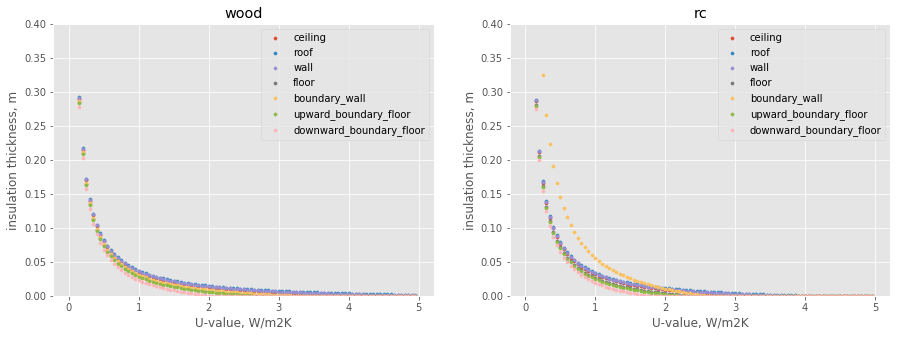

In [27]:
xs = np.arange(0.05, 5.0, 0.05)

cases = [
    ('ceiling',                 'open_space'),
    ('roof',                    'outdoor'),
    ('wall',                    'outdoor'),
    ('floor',                   'outdoor'),
    ('boundary_wall',           'air_conditioned'),
    ('upward_boundary_floor',   'air_conditioned'),
    ('downward_boundary_floor', 'air_conditioned'),
]

fig = plt.figure(figsize = (15, 5))
plt.style.use('ggplot')

for i, structure in enumerate(['wood','rc']):
    
    sp = fig.add_subplot(1, 2, i+1)

    sp.set_title(structure)
    sp.set_xlabel('U-value, W/m2K')
    sp.set_ylabel('insulation thickness, m')
    sp.set_ylim(0.0, 0.4)
    
    def get_t(general_part_type, next_space, structure, u_value):
        layers = get_parts_u_value_directly(general_part_type, next_space, structure, u_value)[0]['layers']
        return sum([layer['thickness'] for layer in layers if layer['name'] == 'insulation'])
        
    
    for case in cases:
        
        ys = [get_t(general_part_type=case[0], next_space=case[1], structure=structure, u_value=x) for x in xs]
        sp.scatter(xs, ys, 10, label=case[0])
        
    sp.legend()

plt.show()

### 2. 詳細入力（木造・RC造等）

In [28]:
parts=[
    {
        'name' : 'part_1',
        'layers' : [ 
            { 
                'name':'layer_1',
                'heat_resistance_input_method':'conductivity',
                'thermal_conductivity':1.6,
                'thickness':0.12,
                'volumetric_specific_heat':120.0,
            },
            { 
                'name':'layer_2',
                'heat_resistance_input_method':'conductivity',
                'thermal_conductivity':1.6,
                'thickness':0.12,
                'volumetric_specific_heat':120.0,
            }
        ],
    }
]
get_parts_detail_method(parts)

[{'name': 'part_1',
  'area_ratio': 1.0,
  'layers': [{'name': 'layer_1',
    'heat_resistance_input_method': 'conductivity',
    'thermal_conductivity': 1.6,
    'thickness': 0.12,
    'volumetric_specific_heat': 120.0},
   {'name': 'layer_2',
    'heat_resistance_input_method': 'conductivity',
    'thermal_conductivity': 1.6,
    'thickness': 0.12,
    'volumetric_specific_heat': 120.0}]}]